In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
import joblib

In [2]:
# os.chdir('../')

In [ ]:
df1 = pd.read_csv('../dataset/Synthetic_Financial_datasets_log.csv')

In [ ]:
df1

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


## Undersampling

Pada tahap ini, dilakukan undersampling terhadap imbalance data

In [ ]:
df1.isFraud.value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [ ]:
df1[df1.isFraud==1].iloc[:4000].shape

(4000, 11)

In [ ]:
df1[df1.isFraud==0].iloc[:4000].shape

(4000, 11)

In [ ]:
df = pd.concat(
    [df[df.isFraud==1].iloc[:4000],
     df1[df1.isFraud==0].iloc[:4000]],
)

In [9]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.00,C972765878,0.00,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.00,C1007251739,26202.00,0.00,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.00,C1848415041,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...
4019,3,CASH_IN,229961.93,C428061834,3829576.42,4059538.35,C451111351,2790518.38,2560556.45,0,0
4020,3,CASH_IN,344337.25,C1654300454,4059538.35,4403875.60,C1590550415,18122628.70,17778291.45,0,0
4021,3,CASH_IN,81874.56,C192486017,4403875.60,4485750.16,C1721246982,1259045.81,1177171.25,0,0
4022,3,CASH_IN,54663.15,C1133617880,4485750.16,4540413.31,C2118255842,471244.99,416581.85,0,0


In [ ]:
# df.to_csv("../dataset/Synthetic_Financial_datasets_log_balanced.csv", index=True, index_label='baris')

## Data Understanding

### Informasi Kolom pada Dataset:
1. `step`: Merepresentasikan unit waktu dalam dunia nyata, di mana 1 langkah (step) setara dengan 1 jam. Total durasi simulasi mencakup 744 langkah, yang setara dengan 30 hari kalender.

2. `type`: Jenis transaksi yang dilakukan, mencakup kategori: CASH-IN (Setor Tunai), CASH-OUT (Tarik Tunai), DEBIT, PAYMENT (Pembayaran), dan TRANSFER.
3. `amount`: Nominal jumlah uang yang ditransaksikan dalam mata uang lokal.
4. `nameOrig`: Identitas pelanggan yang memulai transaksi (pengirim).
5. `oldbalanceOrg`: Saldo awal rekening pengirim sebelum transaksi dilakukan.
6. `newbalanceOrig`: Saldo akhir rekening pengirim setelah transaksi selesai.
7. `nameDest`: Identitas penerima transaksi (tujuan).
8. `oldbalanceDest`: Saldo awal rekening penerima sebelum transaksi. (Catatan: Data ini tidak tersedia untuk penerima yang teridentifikasi sebagai 'M' atau Merchants/Pedagang).
9. `newbalanceDest`: Saldo akhir rekening penerima setelah transaksi. (Catatan: Data ini tidak tersedia untuk 'M' atau Merchants/Pedagang).
10. `isFraud`: Variabel target yang menandai transaksi penipuan sebenarnya. Ini mengidentifikasi transaksi yang dilakukan oleh pelaku kejahatan (fraudster) dengan tujuan menguras habis saldo rekening nasabah melalui mekanisme TRANSFER dan CASH-OUT.
11. `isFlaggedFraud`: Penanda otomatis oleh sistem untuk transfer ilegal berskala besar antar rekening. Setiap transaksi tunggal yang melebihi nominal 200.000 dianggap sebagai percobaan ilegal/tidak sah.

In [10]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0


In [11]:
df.shape

(8000, 11)

In [12]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 2 to 4023
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            8000 non-null   int64  
 1   type            8000 non-null   object 
 2   amount          8000 non-null   float64
 3   nameOrig        8000 non-null   object 
 4   oldbalanceOrg   8000 non-null   float64
 5   newbalanceOrig  8000 non-null   float64
 6   nameDest        8000 non-null   object 
 7   oldbalanceDest  8000 non-null   float64
 8   newbalanceDest  8000 non-null   float64
 9   isFraud         8000 non-null   int64  
 10  isFlaggedFraud  8000 non-null   int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 750.0+ KB


In [14]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [15]:
# Cek duplicated data
df[df.duplicated()]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


In [16]:
# Cek missing values
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## Data Preparation / Cleaning

Tahap ini diperlukan agar dataset yang telah diperoleh dapat digunakan secara optimal oleh model-model Machine Learning pada saat pelatihan model. Pada tahap ini, dilakukan:

- Penghapusan kolom-kolom yang tidak relevan
- Feature Engineering / Feature Extraction
- Encoding

In [17]:
for col in df.select_dtypes(exclude='number').columns:
    print(f"--- Kolom: {col} ---")
    print(df[col].unique())
    print("\n") # Baris baru agar rapi

--- Kolom: type ---
['TRANSFER' 'CASH_OUT' 'PAYMENT' 'DEBIT' 'CASH_IN']


--- Kolom: nameOrig ---
['C1305486145' 'C840083671' 'C1420196421' ... 'C192486017' 'C1133617880'
 'C1202874820']


--- Kolom: nameDest ---
['C553264065' 'C38997010' 'C972765878' ... 'M1279124366' 'M530402062'
 'C979387846']




In [18]:
# Menghapus kolom- kolom tidak relevan
cols_to_drop = ['isFlaggedFraud']

df = df.drop(cols_to_drop, axis=1)

In [19]:
# Feature Engineering

# Hasil: 1 jika Merchant, 0 jika Customer (Binary)
df['isMerchantDest'] = df['nameDest'].apply(lambda x: 1 if x.startswith('M') else 0)

# Menghitung berapa kali nasabah melakukan transaksi
# Jika angkanya tinggi, mungkin akun sedang dikuras atau akun bot
df['countOrig'] = df.groupby('nameOrig')['nameOrig'].transform('count')

# Menghitung berapa kali akun ini menerima uang
# Jika angkanya tinggi, curigai ini sebagai "Akun Penampung" (Mule)
df['countDest'] = df.groupby('nameDest')['nameDest'].transform('count')

df = df.drop(columns=['nameOrig', 'nameDest'])

Fraud HANYA terjadi pada tipe 'TRANSFER' dan 'CASH-OUT'. Tipe lain (PAYMENT, CASH-IN, DEBIT) hampir tidak pernah fraud.

In [20]:
# Encoding kolom `type`

map_strategy = {
    'TRANSFER': 2,
    'CASH_OUT': 2,
    'PAYMENT': 1,
    'CASH_IN': 0,
    'DEBIT': 0
}

df['type_encoded'] = df['type'].map(map_strategy)
df = df.drop(columns=['type'])

In [21]:
cols = list(df.columns)
col_to_move = 'isFraud'

cols.remove(col_to_move)
cols.append(col_to_move)

df = df[cols]

In [22]:
df = df.rename(columns={
    'oldbalanceOrg': 'oldbalanceOrig',
})

In [23]:
# Sampel data setelah data preprocessing
df.head()

,step,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isMerchantDest,countOrig,countDest,type_encoded,isFraud
2,1,181.0,181.0,0.0,0.0,0.0,0,1,1,2,1
3,1,181.0,181.0,0.0,21182.0,0.0,0,1,1,2,1
251,1,2806.0,2806.0,0.0,0.0,0.0,0,1,1,2,1
252,1,2806.0,2806.0,0.0,26202.0,0.0,0,1,1,2,1
680,1,20128.0,20128.0,0.0,0.0,0.0,0,1,1,2,1


## Exploratory Data Analysis (EDA)

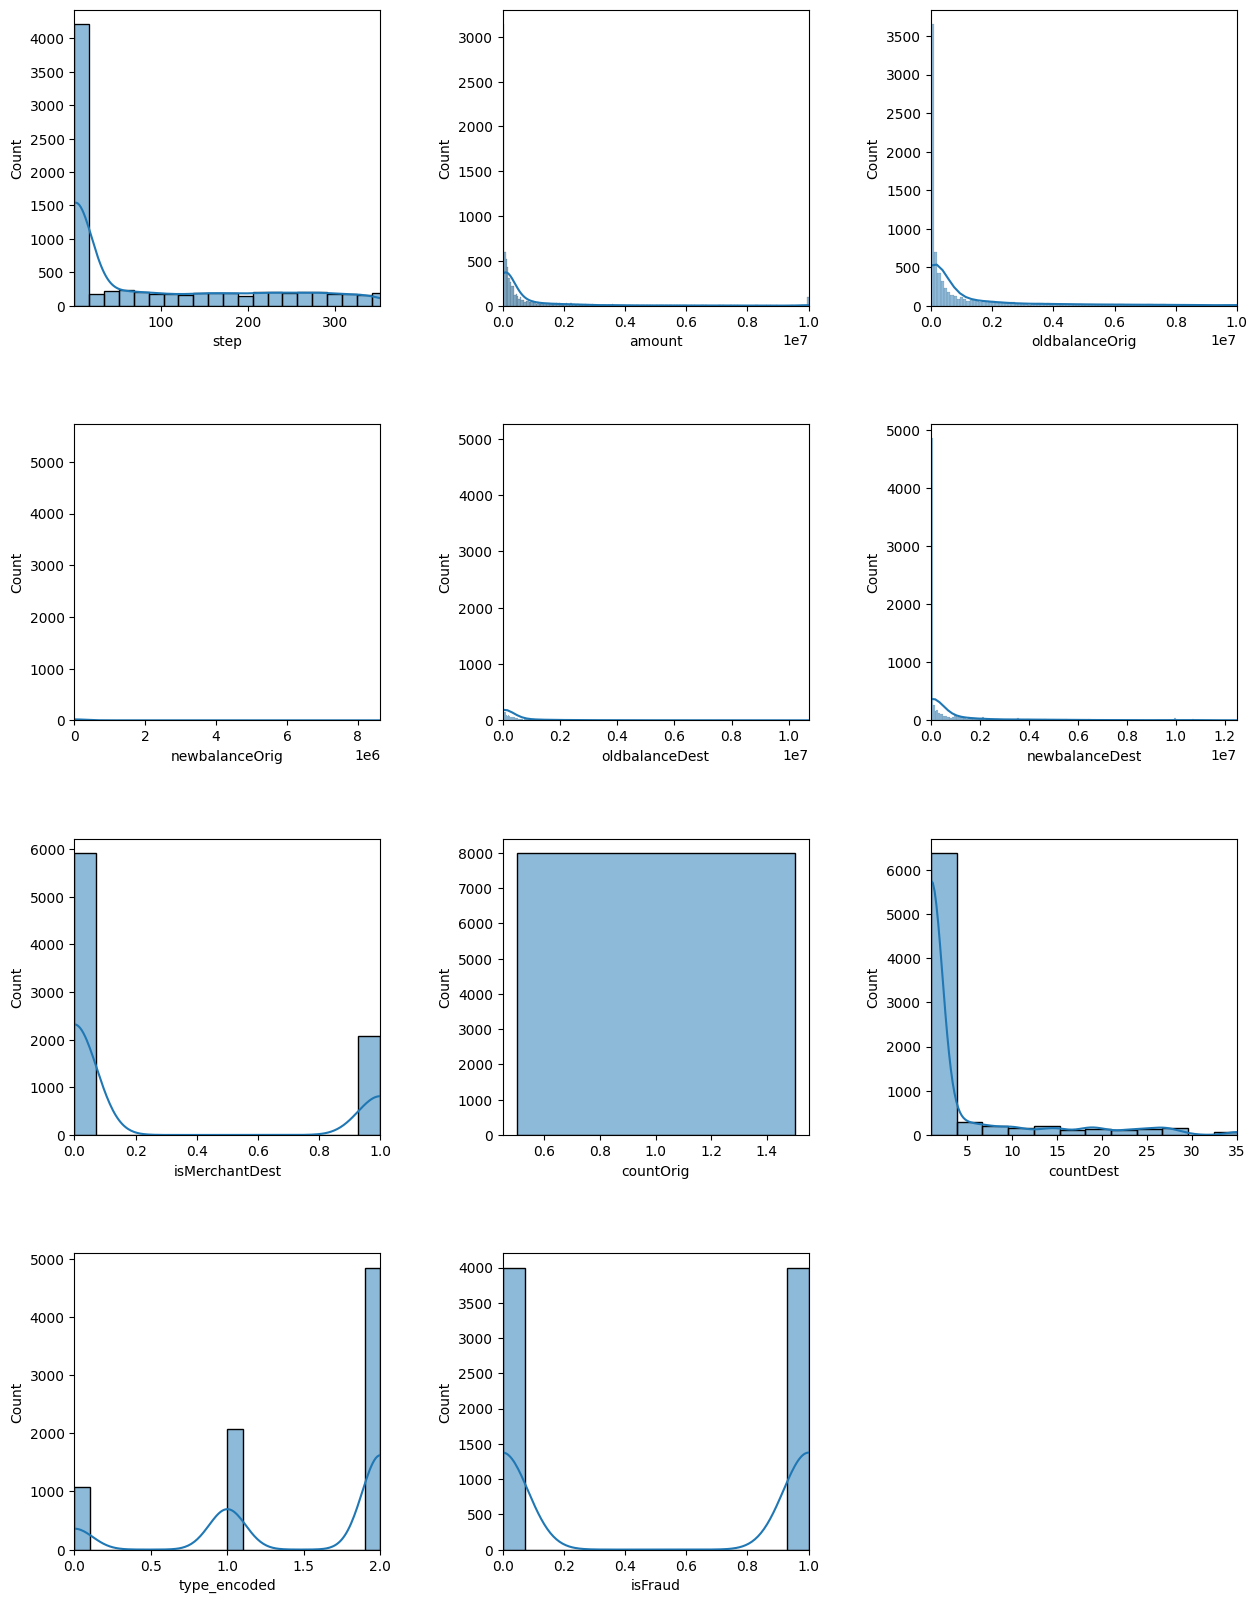

In [24]:
n_cols_grid = 3
n_rows_grid = 4

fig = plt.figure(figsize=(15, 5 * n_rows_grid))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, column in enumerate(df.columns):
    ax = fig.add_subplot(n_rows_grid, n_cols_grid, i + 1)
    sns.histplot(df[column], kde=True, ax=ax)
    upper_limit = df[column].quantile(0.99)
    lower_limit = df[column].min()
    # Set limit hanya jika upper_limit masuk akal (tidak 0 atau NaN)
    if upper_limit > lower_limit:
        ax.set_xlim(lower_limit, upper_limit)
    ax.set_xlabel(column)
    ax.set_xlabel(column)

plt.show()

isFraud
1    4000
0    4000
Name: count, dtype: int64


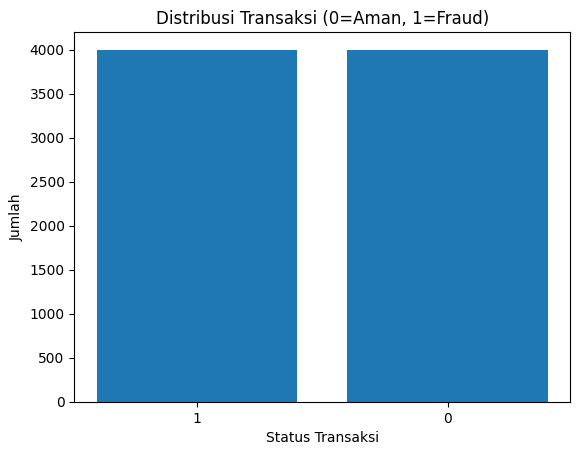

In [25]:
counts = df['isFraud'].value_counts()
print(counts)

# Plot: x=Indexnya (Kategori), height=Valuesnya (Jumlah)
# .astype(str) digunakan agar sumbu X dianggap teks "0" dan "1", bukan angka urut
plt.bar(counts.index.astype(str), counts.values)

plt.title('Distribusi Transaksi (0=Aman, 1=Fraud)')
plt.xlabel('Status Transaksi')
plt.ylabel('Jumlah')
plt.show()

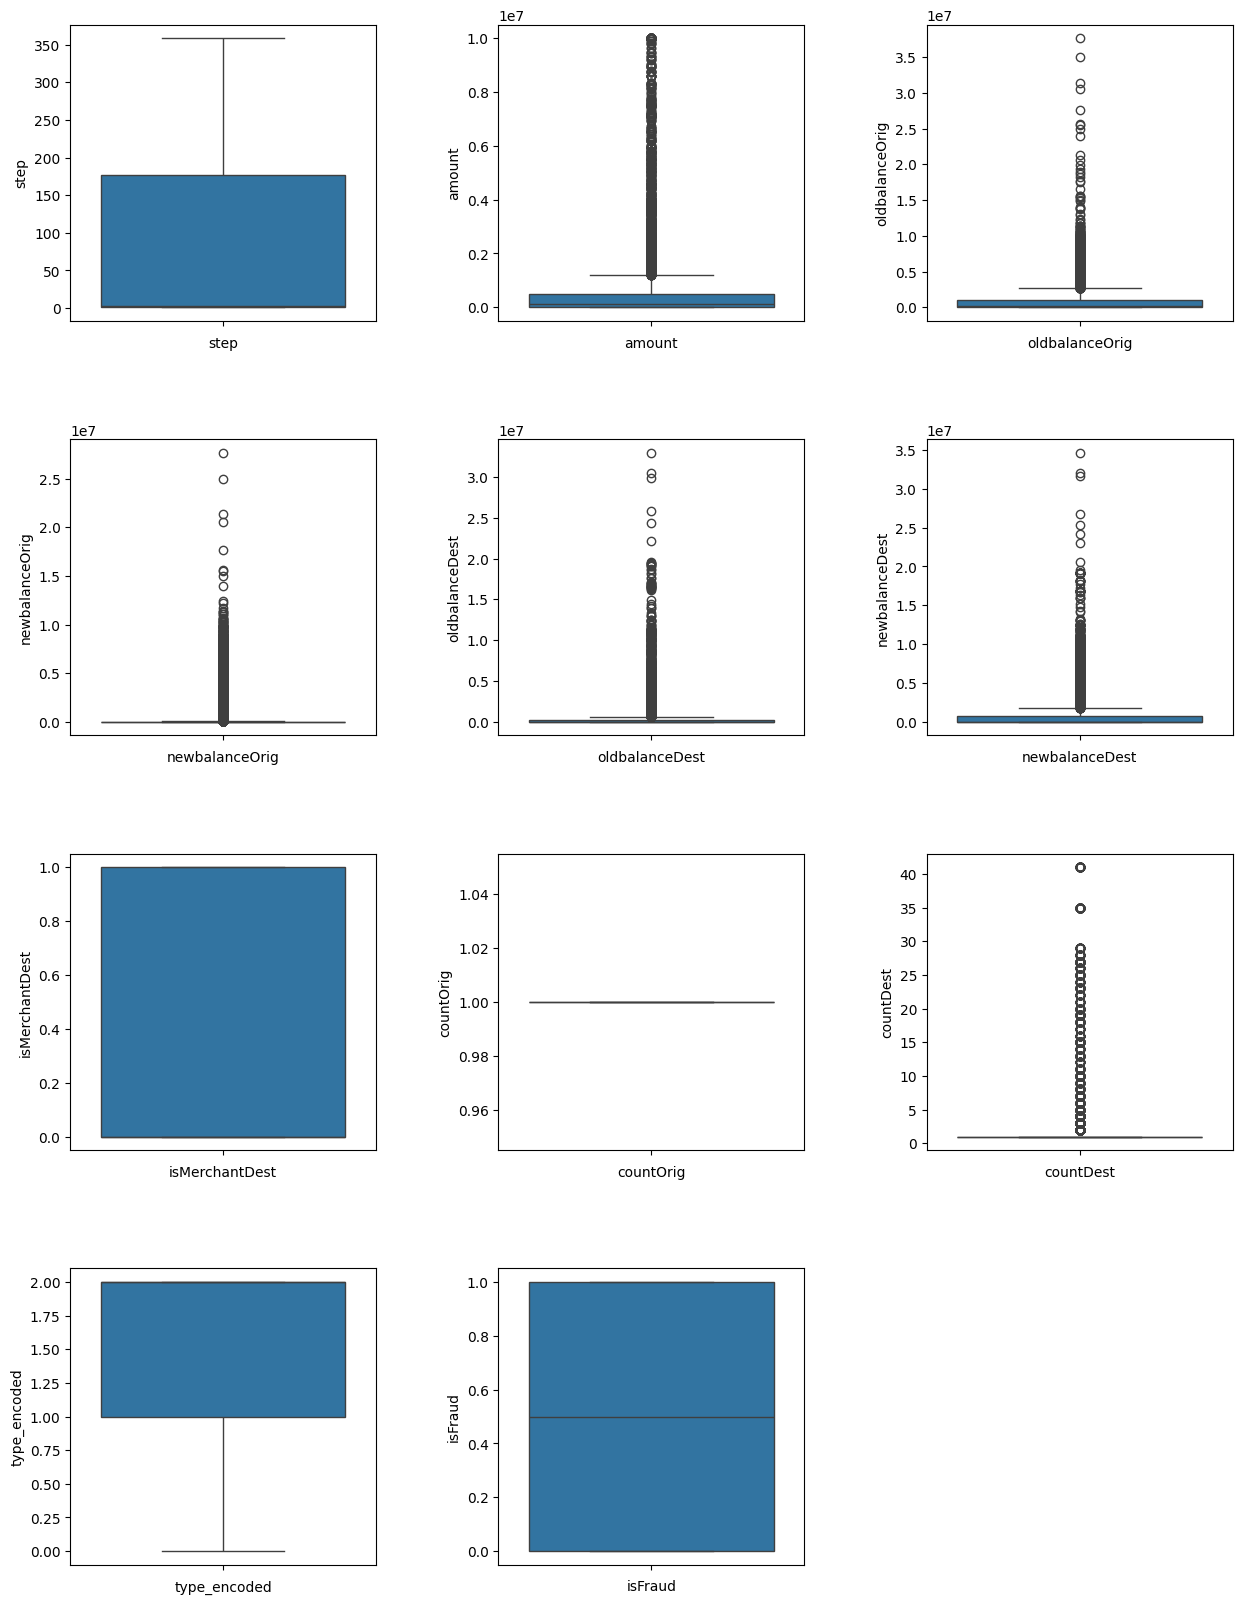

In [26]:
n_cols_grid = 3
n_rows_grid = 4

fig = plt.figure(figsize=(15, 5 * n_rows_grid))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, column in enumerate(df.columns):
    ax = fig.add_subplot(n_rows_grid, n_cols_grid, i + 1)
    sns.boxplot(df[column], ax=ax)
    ax.set_xlabel(column)

plt.show()

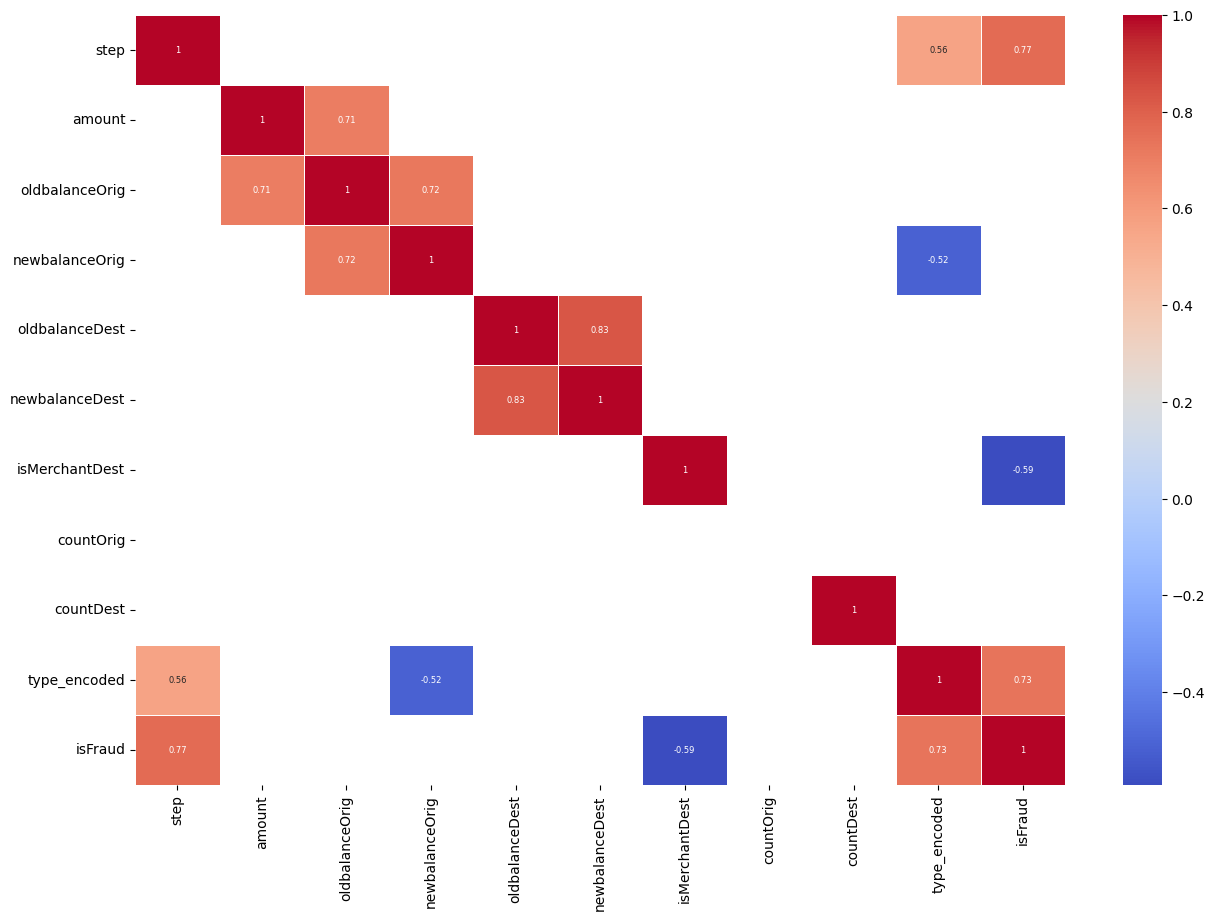

In [27]:
corr = df.corr()
strong_corr = corr[(corr >= 0.5) | (corr <= -0.5)]

plt.figure(figsize=(15, 10))
sns.heatmap(strong_corr, annot=True, cmap="coolwarm", linewidths=0.5, annot_kws={"size": 6})
plt.show()

## Feature Selection

Pada tahap ini, dilakukan penghapusan kolom- kolom yang bersifat multicollinearity

In [28]:
cols_to_remove = [
    'step',
    'newbalanceOrig',
    'newbalanceDest',
    'countDest'
]

In [29]:
df.drop(cols_to_remove, axis=1, inplace=True)

In [31]:
df.to_csv('../dataset/cleaned_Synthetic_Financial_datasets_log_balanced.csv')

## Train Test Split

In [32]:
RANDOM_STATE = 42

In [33]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

## Pelatihan Model (Hyperparameter Tuning)

In [34]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [35]:
# Menghitung scale_pos_weight
ratio = float(np.sum(y == 0)) / np.sum(y == 1)

In [36]:
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 8],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    # Kita berikan opsi: pakai ratio normal, atau ratio yang diperkuat
    'scale_pos_weight': [ratio, ratio * 1.5, 100] 
}

In [37]:
xgb = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss')

In [38]:
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    cv=skf,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [39]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=100, scale_pos_weight=1.0, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=300, scale_pos_weight=100, subsample=0.9; total time=   4.0s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=100, scale_pos_weight=1.0, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=8, min_child_weight=3, n_estimators=200, scale_pos_weight=100, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=100, scale_pos_weight=1.0, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=5, n_es

,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.7, 0.8, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 4, ...], ...}"
,n_iter,20
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [40]:
# Menampilkan parameter terbaik
print(f"Parameter Terbaik: {random_search.best_params_}")
print(f"Skor F1 Terbaik: {random_search.best_score_:.4f}")

# Ambil model terbaik untuk diproses lebih lanjut
best_model = random_search.best_estimator_

Parameter Terbaik: {'subsample': 0.9, 'scale_pos_weight': np.float64(1.0), 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.9}
Skor F1 Terbaik: 0.9888


              precision    recall  f1-score   support

           0       0.99      0.98      0.99       800
           1       0.98      0.99      0.99       800

    accuracy                           0.99      1600
   macro avg       0.99      0.99      0.99      1600
weighted avg       0.99      0.99      0.99      1600



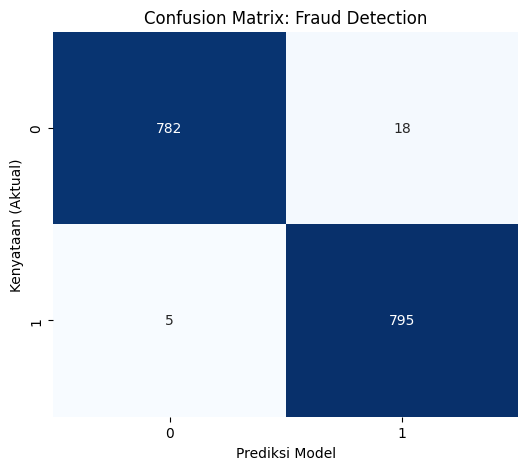

In [41]:
# Prediksi data test
y_pred = best_model.predict(X_test)

# 1. Print Laporan Lengkap
print(classification_report(y_test, y_pred))

# 2. Visualisasi Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Prediksi Model')
plt.ylabel('Kenyataan (Aktual)')
plt.title('Confusion Matrix: Fraud Detection')
plt.show()

In [42]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

In [43]:
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {auc_score:.4f}")

ROC-AUC Score: 0.9966


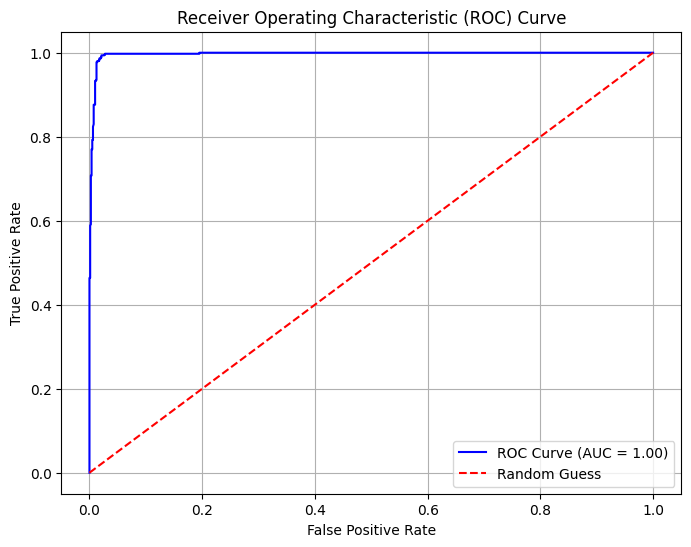

In [44]:
# Hitung FPR, TPR, dan Thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Simpan model ke file
# 'model' adalah variabel nama model Anda yang sudah di-training (.fit)
joblib.dump(best_model, '../artifacts/fraud_detection_model_balanced.joblib')
print("Model berhasil disimpan!")

Model berhasil disimpan!


In [47]:
# Load model dari file
loaded_model = joblib.load('../artifacts/fraud_detection_model_balanced.joblib')

# Coba prediksi
loaded_model.predict(X_test)

array([1, 0, 1, ..., 0, 1, 1], shape=(1600,))